<a href="https://colab.research.google.com/github/dahifi/notebooks/blob/main/ATLAS_Locker_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Requirements

In [1]:
%pip install requests
import requests
import json
import pandas as pd
from pprint import pprint as pp
from google.colab import data_table
data_table.enable_dataframe_formatter()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Get SQL Data and generate `atl` dataset

In [9]:
ATL_EVENTS_API='https://node-api.flipsidecrypto.com/api/v2/queries/76cc6bfa-f171-4c82-a237-7ad217c54891/data/latest'
response = requests.get(ATL_EVENTS_API)
atl_events=pd.DataFrame(response.json())
atl_events['BLOCK_TIMESTAMP'] = pd.to_datetime(atl_events['BLOCK_TIMESTAMP'])

ATL_TX_API='https://node-api.flipsidecrypto.com/api/v2/queries/ca3f712a-e382-490b-b3bf-e2b5c8e3b1f8/data/latest'
response = requests.get(ATL_TX_API)
atl_tx = pd.DataFrame(response.json())
atl_tx['SIGNERS'] = atl_tx['SIGNERS'].apply(lambda x: x[0])
atl_tx['BLOCK_TIMESTAMP'] = pd.to_datetime(atl_tx['BLOCK_TIMESTAMP'])

print("Last event: ", atl_events['BLOCK_TIMESTAMP'].sort_values().max())
print("Last tx: ", atl_tx['BLOCK_TIMESTAMP'].sort_values().max())

atl = pd.merge(atl_events, atl_tx, on=['BLOCK_TIMESTAMP', 'BLOCK_ID', 'TX_ID', 'SUCCEEDED'])

Last event:  2022-11-21 12:27:59
Last tx:  2022-11-21 14:35:53


## Parse Instructions

In [10]:
def atl_instruction_parser(instruction):
  data = instruction['data'][:2]
  events = {
      # USER FUNCTIONS
      'i4': 'CreateStakingAccount',
      'Hr': 'StakeTokens', 
      'An': 'UnstakeTokens',
      'Bk': 'CancelUnstake',
      'fJ': 'Harvest',
      'Lb': 'WithdrawTokens',
      # ADMIN FUNCTIONS
      'J6': 'RegisterStake', 
      'Aq': 'Settle', 
      'BV': 'UpdateRewardMultiplier', 
      'Xo': 'InitializeStaking',

  }
  if events.get(data) is not None:
    return events.get(data)
  else:
    print ("Unknown instruction: ", data)
    return data

atl['EVENT_TYPE'] = atl['INSTRUCTION'].apply(atl_instruction_parser)
atl = atl.drop(['SUCCEEDED', 'PROGRAM_ID', 'RECENT_BLOCK_HASH', 'FEE', 'INNER_INSTRUCTIONS'], axis=1)

# Get spl-token xfer amount from inner instructions and convert to float
def get_parsed_amount(inner_instructions):
    for inner in inner_instructions: 
     result = inner['instructions'][0].get('parsed', {}).get('info', {}).get('amount')
     if result is not None:
       return float(result) / 10.0**8.0

# Use this DF to search by pubkey
indexed = atl.set_index('SIGNERS')

## Locker rewards calculation

### Narrow focus to one wallet and generate `saia_activity` df

In [11]:
# strip down to one wallet so we can make sure we're calculating the balance correctly 
temp = atl
saia='E3i4y9EGLL1i4E66Wbjh6p9oxUTyQRGLECahcNLMeTBS'
saia_activity = temp[temp['SIGNERS']==saia]

new_index=['BLOCK_ID', 'EVENT_TYPE']
saia_activity = saia_activity.set_index(new_index) 


### Reindex by date


In [226]:
def calculate_locked(df):
  result = df['atlas_locked'] + df ['atlas_in'] - df['atlas_out']
  df['atlas_locked'] = df['atlas_locked'].add(df['atlas_in'], fill_value=0.0).sub(df['atlas_out'], fill_value=0.0).cumsum()


def parse_df(df):
  print('start parse')
  df['atlas_in'] = df[df.index.isin(["StakeTokens"], level=1)]['INNER_INSTRUCTION'].apply(calculate_balance)
  df['atlas_out'] = df[df.index.isin(["WithdrawTokens"], level=1)]['INNER_INSTRUCTION'].apply(calculate_balance)
  df['atlas_locked'] = 0

  calculate_locked(df)
  return

def calculate_balance(df):
  for s in df['instructions']:
    result = s['parsed']['info'].get('tokenAmount', {}).get('uiAmount')
    if result is not None:
      return result
  
  return 0.0



In [228]:
new_index=['BLOCK_ID', 'EVENT_TYPE']
df = atl.set_index(new_index) 
#parse_df(df)

#df[['atlas_in', 'atlas_out', 'atlas_locked']]
df

BLOCK_TIMESTAMP  \
BLOCK_ID  EVENT_TYPE                        
159126731 Settle      2022-11-03 23:58:14   
          Settle      2022-11-03 23:58:14   
          Settle      2022-11-03 23:58:14   
          Settle      2022-11-03 23:58:14   
          Settle      2022-11-03 23:58:14   
...                                   ...   
159870842 Settle      2022-11-07 23:22:50   
159871142 Settle      2022-11-07 23:25:07   
159870284 Settle      2022-11-07 23:18:18   
157150052 StakeTokens 2022-10-24 14:08:52   
157202150 Harvest     2022-10-24 20:37:00   

                                                                   TX_ID  \
BLOCK_ID  EVENT_TYPE                                                       
159126731 Settle       3bfmhBtuuooU2VEhURyJYcH3oCvtdTd4Mtw761Dr2a8SBh...   
          Settle       3bfmhBtuuooU2VEhURyJYcH3oCvtdTd4Mtw761Dr2a8SBh...   
          Settle       3bfmhBtuuooU2VEhURyJYcH3oCvtdTd4Mtw761Dr2a8SBh...   
          Settle       3bfmhBtuuooU2VEhURyJYcH3oCvtdTd4Mtw761Dr2a8SBh...   
          Settle       3bfmhBtuuooU2VEhURyJYcH3oCvtdTd4Mtw761Dr2a8SBh...   
...                                                                  ...   
159870842 Settle       2RpGv2r8hSSEVnAa5mYzMENwe8womUxruW6gxbtAkyjCfq...   
159871142 Settle       38FLX1T8s4rNxX46goaQVWTXpntjyzfS6cg9RhJPyp4hn3...   
159870284 Settle       3Uk6dNy5k8hJugpPq7suJ1BsWScV866xDMt9osoKZdKB28...   
157150052 StakeTokens  4u5BatDWuGUfAh9ru4mTvFUXUoUdEWcMun2SXqkTvua97e...   
157202150 Harvest      V1HjJGzYdCAzegg6jfQuEQMuhVke8tFppbazQ1vBoZD6RU...   

                       INDEX  \
BLOCK_ID  EVENT_TYPE           
159126731 Settle           0   
          Settle           1   
          Settle           2   
          Settle           4   
          Settle           3   
...                      ...   
159870842 Settle           0   
159871142 Settle           0   
159870284 Settle           3   
157150052 StakeTokens      0   
157202150 Harvest          0   

                                                             INSTRUCTION  \
BLOCK_ID  EVENT_TYPE                                                       
159126731 Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
          Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
          Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
          Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
          Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
...                                                                  ...   
159870842 Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
159871142 Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
159870284 Settle       {'accounts': ['ATLkZsBofSKG845dNFpNoUyMciGpeH2...   
157150052 StakeTokens  {'accounts': ['CXb81r25FDrFNFMUGay6qsKrmaQhB7t...   
157202150 Harvest      {'accounts': ['b1Q4NWpsj9aBwuut3HMWDqo31M8PSog...   

                                                       INNER_INSTRUCTION  \
BLOCK_ID  EVENT_TYPE                                                       
159126731 Settle                                                    None   
          Settle                                                    None   
          Settle                                                    None   
          Settle                                                    None   
          Settle                                                    None   
...                                                                  ...   
159870842 Settle                                                    None   
159871142 Settle                                                    None   
159870284 Settle                                                    None   
157150052 StakeTokens  {'index': 0, 'instructions': [{'parsed': {'inf...   
157202150 Harvest      {'index': 0, 'instructions': [{'parsed': {'inf...   

                                                        

246514

## Other random shit

In [ ]:
'''
There's some weirdness between the instruction and CPI call instructions, this code needs cleanup
'''


# Get spl-token xfer amount from inner instructions and convert to float
def get_parsed_amount_iis(inner_instructions):
    for inner in inner_instructions: 
      type = inner['instructions'][0]['parsed']['type']
      print(type)

      if type == 'transferChecked':
        print (inner['instructions'][0].get('parsed', {}).get('info', {}).get('tokenAmount'))

        result = inner['instructions'][0].get('parsed', {}).get('info', {}).get('amount')
        if result is not None:
          return float(result) / 10.0**8.0

# EXAMPLE
# indexed['INNER_INSTRUCTIONS'].apply(get_parsed_amount_iis)

# Get spl-token xfer amount from inner instructions and convert to float
def get_uiAmountString(inner_instruction):
  if inner_instruction is None: 
    return
  for instruction in inner_instruction['instructions']:
    type = instruction['parsed']['type']
  #print(type)

  if type == 'transferChecked':
    result = instruction['parsed']['info']['tokenAmount']['uiAmountString']
    if result is not None:
      return float(result)

indexed['INNER_INSTRUCTION'].apply(get_uiAmountString)
atl['AMOUNT_LOCKED'] = atl[atl['EVENT_TYPE']=="StakeTokens"]['INNER_INSTRUCTION'].apply(get_uiAmountString)

In [ ]:
# UNUSED

def parse_atl(df):
  df['INNER_INSTRUCTION'].apply(get_uiAmountString)

parse_atl(atl)

In [ ]:
atl['AMOUNT_LOCKED'] = atl[atl['EVENT_TYPE']=="StakeTokens"]['INNER_INSTRUCTION'].apply(get_uiAmountString)

# need to filter out unlocks, relocks to make sure is accurate. 

atl['AMOUNT_LOCKED'].sum()

360813471.0

In [ ]:
atl['SIGNERS'].count


<bound method Series.count of 0        6razFVCBVsgTehewSNiw1Z3QLgm7u9pDsAh1mWPeZN72
1        3RRHks9GY15iqDMwNNwhzs98k8jAQrD8HydZujDgguMx
2        CXb81r25FDrFNFMUGay6qsKrmaQhB7t2seHzJap6XpEG
3        HFEY7F9cewA6BRtb55G55aneKyfHdaws6Rq3cmjrT8Pj
4        9KReFbqiQju1TrEGsvUjgLXWpNeQVatqB9qhTS6qNfb1
                             ...                     
32619    2WL55aHoxdS7qAuLD4WTErFWApzbFwtqPYcbbf99kSGZ
32620    2SZM7JVfFd78fXTup5WA2npxU1nRLpt1ELVh6CjbGdED
32621    CDweRnLihwDynQJU4rEssDRA3suJpBT7ZCHyeDNXNmBo
32622    F67fNRReEaKKV5Pnqsa2kuhbiKRWypoVNwSpVVF375vB
32623    3Vx9VSpRgEvwzeohJNSGnbdqTEn8BUzEmByya9hYEgb6
Name: SIGNERS, Length: 32624, dtype: object>

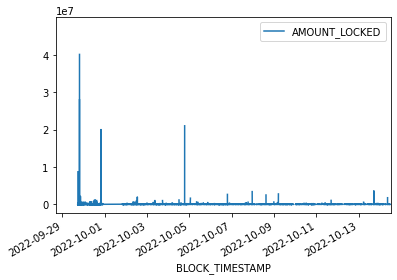

In [ ]:
atl.loc[:, ['BLOCK_TIMESTAMP', 'AMOUNT_LOCKED']].plot(
    x="BLOCK_TIMESTAMP",
    xlim=('2022-09-28 16:24:09','2022-10-14 12:20:41')
)

In [ ]:
atl.loc[:, ['SIGNERS', 'AMOUNT_LOCKED']].sort_values(by='AMOUNT_LOCKED', ascending=False).loc[:10]

,SIGNERS,AMOUNT_LOCKED
32567,EkAszkHzR5f7zEuMQSR8HCh3BiCCUpqbDYtpdXyf83Dd,47607324.0
32559,2Qi6MRZizThcMDuGbrBg8vHpBNjG8fxxqYsqzFpszzZq,40088288.0
32427,9kRStApfGXAZy3KmKxTYqrfCLLxcPBy6XyVvouRm33rE,27946245.0
22508,dzXygJ7XHy5LaxNApu4kwRM5gwck4DbxePmkLsXAnB4,21000000.0
30526,DMWRJ1KywvTxJAUbgLkkPgpbPbXtCY6B8eVmsgHgZJDi,20000000.0
...,...,...
29357,BrJkBZvEehpFKDdyiHhFpGNhrP955SCYE6zph7LY2VrH,10774.0
28909,c9L84ndVFZkJP24idb4MGXk2ku5FTpSk2MoLCMXyYcd,10752.0
3435,DvCAMHui87TAQFgo8HRAx5y9J2pKULEFUoJQFNoDZaSZ,10727.0
4861,95cJPJc4k9uhWwtp9t1bYGDAztTmzQkCTrgZwpGPDopH,10727.0


In [ ]:
# doesn't return useful info
atl[atl['EVENT_TYPE']=="UnstakeTokens"]['INNER_INSTRUCTION'].apply(get_parsed_amount_ii)
atl[atl['EVENT_TYPE']=="CancelUnstake"]['INNER_INSTRUCTION'].apply(get_parsed_amount_ii)
atl[atl['EVENT_TYPE']=="UnstakeTokens"]['INNER_INSTRUCTIONS'].apply(get_parsed_amount_iis)
atl[atl['EVENT_TYPE']=="CancelUnstake"]['INNER_INSTRUCTIONS'].apply(get_parsed_amount_iis)

NameError: ignored

In [ ]:
atl.count

In [ ]:
initial_stakes = atl[atl['EVENT_TYPE']=='NewProxyEscrow']
initial_stakes = pd.merge(initial_stakes, gate_txs, on='TX_ID')
initial_stakes['INITIAL_STAKE'] = initial_stakes['INNER_INSTRUCTIONS'].apply(get_parsed_amount)
initial_stakes['INITIAL_STAKE']

claim_rewards = gate_events[gate_events['EVENT_TYPE']=='ClaimRewards']
claim_rewards = pd.merge(claim_rewards, gate_txs, on='TX_ID')
claim_rewards['POLIS_XFER'] = claim_rewards['INNER_INSTRUCTIONS'].apply(get_parsed_amount)
claim_rewards['POLIS_XFER']

secondary_stakes = gate_events[gate_events['EVENT_TYPE']=='ProxyLock']
secondary_stakes = pd.merge(secondary_stakes, gate_txs, on='TX_ID')
secondary_stakes['SECONDARY_STAKE'] = secondary_stakes['INNER_INSTRUCTIONS'].apply(get_parsed_amount)

NameError: ignored

In [ ]:
# Get Settle TXs
#atl.loc[:, ['SIGNERS', 'AMOUNT_LOCKED']].sort_values(by='AMOUNT_LOCKED', ascending=False).loc[:10]
#atl[atl['EVENT_TYPE'] == "Settle"].sort_values(by='TX_ID')[:10]
atl[atl['EVENT_TYPE']== "Settle" ]['TX_ID'][264]

'Y8Woz7KxqVgLABE6qQBtfWn2YHP62CjEFWpvnfbMicVpY4rDSX7ZoahVXjhDeLNE8GyZEGCc5A6togwapRrf4BN'